In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
import sys, io
import pandas as pd 
from ipynb.fs.full.Data_Processing import *
from ipynb.fs.full.evaluation import *
from braindecode.datasets.xy import create_from_X_y
from braindecode.training.losses import CroppedLoss
import time
import numpy as np
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet , Deep4Net 
from skorch.callbacks import LRScheduler, EarlyStopping
from skorch.helper import predefined_split
from braindecode import EEGClassifier , EEGRegressor
from collections import namedtuple
import pickle
from sklearn.model_selection import KFold

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

In [3]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [4]:
def choose_cnn (model_depth, model_type, trainset, validset , n_classes , device, cuda , n_epochs):
    # Extract number of chans and time steps from dataset
    n_chans = trainset[0][0].shape[0]
    input_window_samples = trainset[0][0].shape[1]

    if model_depth == 'shallow':
        lr = 0.0625 * 0.01
        weight_decay = 0
        model =  ShallowFBCSPNet(n_chans, n_classes, input_window_samples=input_window_samples, final_conv_length="auto")
    else:
        lr = 1 * 0.01
        weight_decay = 0.5 * 0.001
        """
        For 30 samples, filter time_length = 1
        For 60 > samples, filter time length is left empty
        for 15 samples, filter_time length = 1, filter_length_2 = 1, filter_length_3 = 1
        """
        model =  Deep4Net(n_chans, n_classes, input_window_samples=input_window_samples,
                  final_conv_length='auto', pool_time_length=1, filter_time_length = 1,pool_time_stride=1)
    if cuda:
        model = model.cuda(0)

    batch_size = 32
    
    if model_type == 'clf':
        clf = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(validset),  # using valid_set for validation
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        callbacks=[
            "accuracy", 
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)), 
           ("EarlyStopping", EarlyStopping(monitor = 'valid_loss', threshold = 0.00001)),
        ],
        device=device,)
        return clf
    else:
        
        # remove softmax
        new_model = torch.nn.Sequential()
        for name, module_ in model.named_children():
            if "softmax" in name:
                continue
            new_model.add_module(name, module_)
            
        model = new_model

        regressor = EEGRegressor(
        model,
        cropped = False,
        criterion=CroppedLoss,
        criterion__loss_function=torch.nn.functional.mse_loss,
        optimizer=torch.optim.AdamW,
        train_split=predefined_split(validset),
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        iterator_train__shuffle=True,
        batch_size=batch_size,
        callbacks=[
            "neg_root_mean_squared_error",
            # seems n_epochs -1 leads to desired behavior of lr=0 after end of training?
            ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)), 
           ("EarlyStopping", EarlyStopping(monitor = 'valid_loss', threshold = 0.00001)),
        ],
        device=device)
        return regressor
        

In [5]:
def average(lst): 
    return sum(lst) / len(lst)

In [6]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [7]:
def is_slice_in_list(s,l):
    """
    Function for checking whether a slice is in a list. Mainly used for checking whether the 
    """
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [8]:
def kfold_predict (X,y, model_type, n_epochs, model_depth):
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)

    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}

    total_predictions = []
    total_true = []
    num_classes = 0
    clf = None
    for train_index, test_index in kf.split(X):
        print("Train: ", train_index, "Validation: ", test_index)

        #Train/test split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        # check the the classes in the validation set
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))
        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        print(set(y_train))
        print(set(y_valid))

        size = len(X_train) + len(X_valid) #get dataset size

        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables
        if model_type == 'clf':
            y_train, y_valid, le = categorise(y_train, y_valid)
            
        # Convert training and validation sets into a suitable format
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        trainset = create_from_X_y(X_train, y_train, drop_last_window=False)
        validset = create_from_X_y(X_valid, y_valid, drop_last_window=False)
        sys.stdout = save_stdout

        # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))

        # commence the training process
        time_start = time.time()
        save_stdout = sys.stdout
        sys.stdout = open('/cs/tmp/ybk1/trash', 'w')
        cnn = choose_cnn (model_depth, model_type, trainset, validset , num_classes , device, cuda, n_epochs).fit(trainset, y=None, epochs=n_epochs)
        
        sys.stdout = save_stdout
        print('Training completed created! Time elapsed: {} seconds'.format(time.time()-time_start))

        # make predictions
        if model_type == 'clf':
            y_pred = le.inverse_transform(cnn.predict(X_valid))
            y_true = le.inverse_transform(y_valid)
        else:
            y_pred = cnn.predict(X_valid)
            y_true = y_valid
            
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type)

        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        

    for key in results: # finallly average out the results 
        results[key] = average(results[key])
   
    return results, np.concatenate(total_predictions), np.concatenate(total_true), num_classes, size, cnn

In [9]:
def run_per_user(model_depth, model_type, window_size_samples, n_epochs):
    """
    Method for running the CNN per user
    """
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    

#     saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_with_individual_tests_30_window_annotated_EEG.pickle"
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg.pickle".format(window_size_samples)
    all_tests = load_file(saved_file)
    users = all_tests.keys()

    for user in users:
        print("Working on user {0}".format(user))
        torch.backends.cudnn.benchmark = True

        for label in labels:
            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).transpose(0,2,1).astype(np.float32) for x in dt['inputs']])     
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # train and make predictions
            r, y_pred, y_true, num_classes, size, cnn = kfold_predict(X,y, model_type, n_epochs, model_depth)
            print(r['Accuracy'])

             # get results
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples))

            if model_type == 'clf':
                # plot confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                saved_file = "results/CNN/clf/confusion/k fold/{3}/per user/User_{0}_{1}_epochs_{2}.png".format(user,label,n_epochs,model_depth)
                plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

            #plot loss curve
            plot_loss_curve(cnn)
            plt.savefig("results/CNN/{4}/loss curves/k fold/{3}/per user/User_{0}_{1}_epochs_{2}.png".format(user,label, n_epochs, model_depth,model_type))
            
            if model_type == 'reg':
                saved_file = "results/CNN/reg/y vs y_pred/{3}/per user/CNN_User_{0}_{1}_{2}.png".format(user,label, window_size_samples, model_depth)
                plot_model(y_true, y_pred, user, label,file=saved_file)
                
            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/{3}/tabulated/k fold/{2}/Valid_performance_window_size_{0}_{1}_per_user.csv".format(window_size_samples, n_epochs, model_depth , model_type), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results

In [10]:
# results = run_per_user('deep','clf',120, 1000)

In [11]:
# # save model 
# saved_file = "models/attention_user_1_with_fi.pickle"
# with open(saved_file, 'wb') as handle:            
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
def run_cross_user(model_depth, model_type, window_size_samples, n_epochs ):
    time_original = time.time()

    results = []
    labels = ['attention','interest','effort']
    
#     saved_file = "/cs/home/ybk1/Dissertation/data/all_users_sampled_30_window_annotated_EEG.pickle"
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg.pickle".format(window_size_samples)
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    model_type = 'clf'
    user ='all'
    torch.backends.cudnn.benchmark = True

    

    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()


        # convert the inputs  into #samples, channels, #timepoints format
        X = np.array([all_tests_agg[user]['inputs'].transpose(0,2,1).astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, clf = kfold_predict(X,y, model_type, n_epochs, model_depth)
        print(r['Accuracy'])

         # get results
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples))
        
        # plot confusion matrix
        if model_type == 'clf':   
            cm = confusion_matrix(y_true, y_pred)
            saved_file = "results/CNN/clf/confusion/k fold/{0}/cross user/Label_{1}_n_epochs_{2}.png".format(model_depth, label, n_epochs)
            plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)

        #plot loss curve
        plot_loss_curve(clf)
        plt.savefig("results/CNN/{3}/loss curves/k fold/{1}/cross user/Label_{0}_{2}.png".format(label, model_depth, n_epochs, model_type))
        
        #plot model
        if model_type == 'reg':
            saved_file = "results/CNN/reg/y vs y_pred/{3}/cross user/CNN_User_{0}_{1}_{2}.png".format(user,label, window_size_samples, model_depth)
            plot_model(y_true, y_pred, user, label,file=saved_file)
     
        
        print("Finished analysis on label {0}".format(label))
    print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/{3}/tabulated/k fold/{1}/{1}CNN_Valid_performance_window_size_{0}_cross_user_n_epochs{2}.csv".format(window_size_samples , model_depth,n_epochs, model_type), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))

#     model_path =  "/cs/home/ybk1/Dissertation/data/models/cross_user_30_window.pickle"
#     save_file(model_path,clf)

Working on label attention
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 164.02120780944824 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 190.82377767562866 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 214.01055097579956 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 195.8225541114807 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 161.02378964424133 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.1886934608071212
Normalized confusion matrix
[[0.         0.09819764 0.72591672 0.14729646 0.02858919]
 [0.         0.1284745  0.47318888 0.27270738 0.12562924]
 [0.         0.27280956 0.28475742 0.22682839 0.21560463]
 [0.00335633 0.29628939 0.26589595 0.27913481 0.15532351]
 [0.         0.32826913 0.18529571 0.39365165 0.09278351]]
Finished analysis on label attention
Working on label interest
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 140.26393866539001 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 192.76875710487366 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 130.79327249526978 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 154.6378538608551 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 159.73496294021606 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2040653627802786
Normalized confusion matrix
[[0.         0.11285794 0.11622684 0.64682762 0.12408759]
 [0.         0.07118176 0.08269984 0.7403824  0.10573601]
 [0.         0.28231063 0.1020454  0.46392448 0.15171949]
 [0.         0.31337907 0.09914237 0.44854202 0.13893654]
 [0.         0.12436782 0.16252874 0.5445977  0.16850575]]
Finished analysis on label interest
Working on label effort
Train:  [ 0  1  4  5  7  8  9 10 11 12 14 15 16 17] Validation:  [ 2  3  6 13]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 160.6155505180359 seconds
Train:  [ 0  1  2  3  5  6  8  9 10 11 12 13 16 17] Validation:  [ 4  7 14 15]


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 212.51001906394958 seconds
Train:  [ 2  3  4  5  6  7  8  9 11 12 13 14 15 16] Validation:  [ 0  1 10 17]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 164.30131936073303 seconds
Train:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 17] Validation:  [ 8  9 16]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 282.7299485206604 seconds
Train:  [ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17] Validation:  [ 5 11 12]
{1, 2, 3, 4, 5}
{1, 2, 3, 4, 5}


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training completed created! Time elapsed: 132.91860842704773 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3357907794185864
Normalized confusion matrix
[[3.59861592e-02 8.48212226e-01 6.89734717e-02 4.52133795e-02
  1.61476355e-03]
 [6.87960688e-02 8.14043709e-01 8.97452476e-02 1.64231217e-02
  1.09918531e-02]
 [9.18269231e-02 7.75480769e-01 1.16586538e-01 1.44230769e-02
  1.68269231e-03]
 [3.44827586e-02 8.27586207e-01 1.37274220e-01 6.56814450e-04
  0.00000000e+00]
 [8.11907984e-02 8.37618403e-01 8.11907984e-02 0.00000000e+00
  0.00000000e+00]]
Finished analysis on label effort
Finished analysis on User all
All analyses are complete! Time elapsed: 4008.34051156044


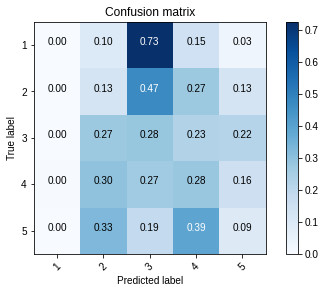

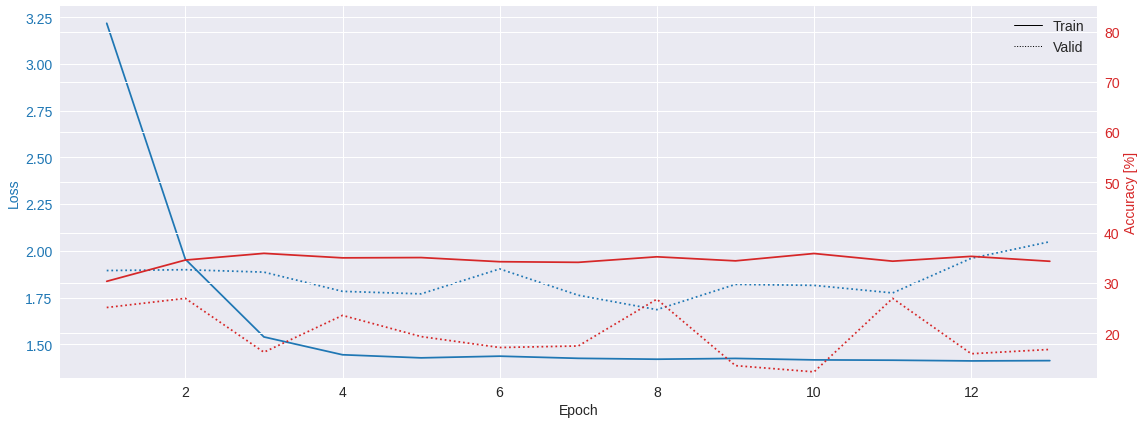

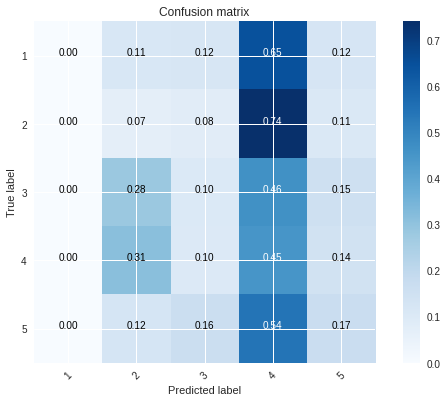

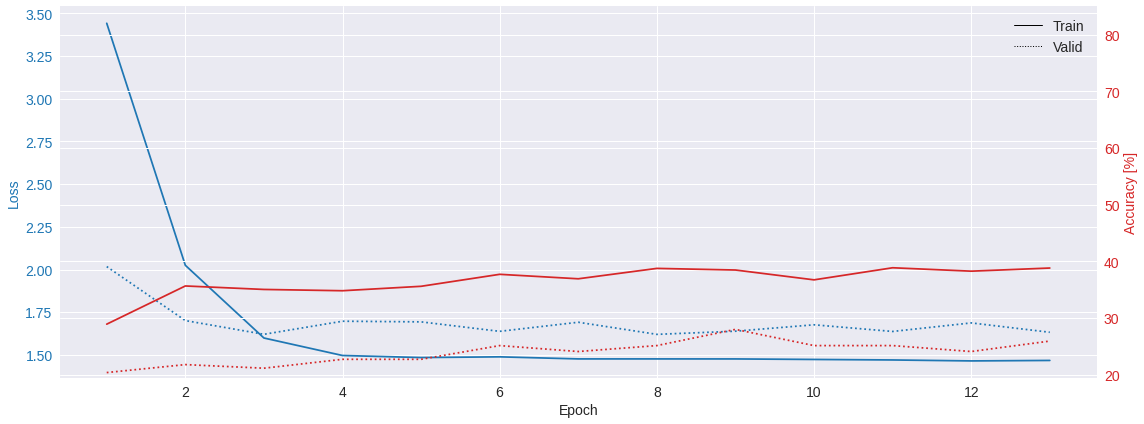

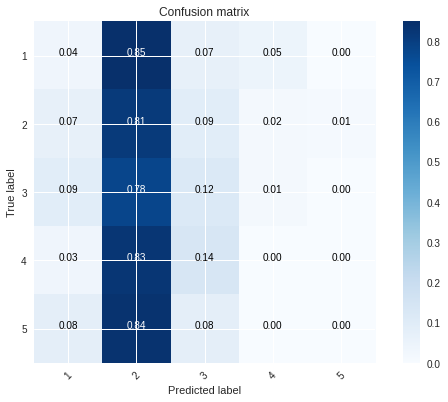

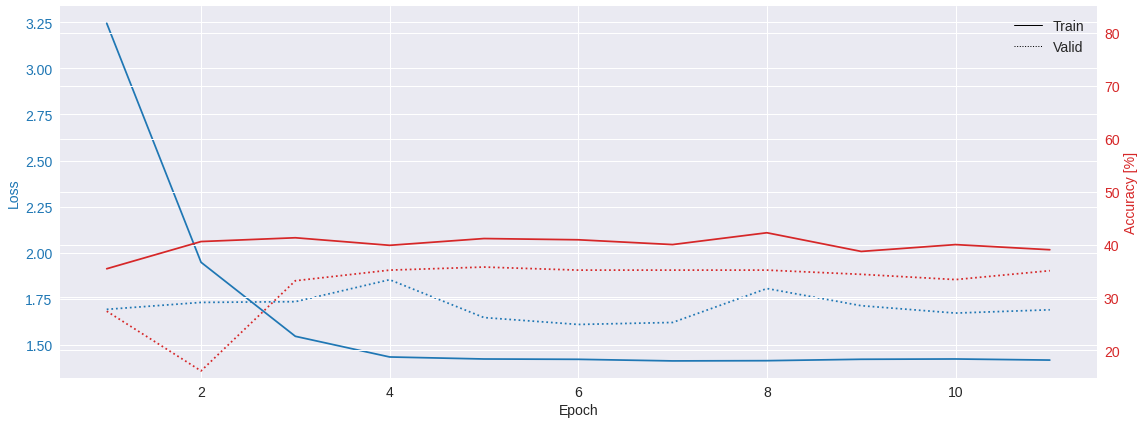

In [13]:
results2 = run_cross_user('shallow','clf',120, 1000)